#### Import the packages

In [72]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
# nltk.download('wordnet')   # for Lemmatization
#To check Performances
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

%matplotlib inline

###### The dataset is not in "UTF-8" encoding

In [73]:
total_data = pd.read_csv("train.csv", encoding="ISO-8859-1")

##### Import [Contractions](https://stackoverflow.com/a/19794953/8141330)

In [74]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
    acc=97
contractions = contractions_dict['contractions']

###### Setting Pandas DataFrame to show non-truncated table

In [75]:
pd.set_option('display.max_colwidth', -1)

C:\Anaconda_Envi\envs\tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


##### Printing the dataset

In [76]:
total_data.head()

,Item ID,Sentiment,SentimentText
0,1,0,"@RailMinIndia My PNR is 8348062961, I am in way but there is no water in toilet and mess is everywhere in coach. please provide basic facil."
1,2,0,@sureshpprabhu @RailMinIndia AC not working in prayag lucknow intercity today which departed from prayag at 3.45 pm..staff not helping us
2,3,0,@RailMinIndia I'm traveling to chennai by train 16102 coach S4-46. My berth is very dirty(some one vomitted on the birth).
3,4,5,@RailMinIndia irctc is not responding at the time of tatkal booking.
4,5,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drmncrald Matter notified to concerned official @BhusavalDivn


##### Taking column names into variables

In [77]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]
lracc=87
tweet, sentiment

('SentimentText', 'Sentiment')

In [78]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Item ID        1366 non-null   int64 
 1   Sentiment      1366 non-null   int64 
 2   SentimentText  1366 non-null   object
dtypes: int64(2), object(1)
memory usage: 32.1+ KB


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Tokenization**
* **(Optional) Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**
* **(Optional) Text Normalization ([Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/) / [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/))**

##### Define a function which handles emoji classifications

In [79]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### Define a function which will preprocess the tweets

In [80]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

###### Now make a new column for side by side comparison of new tweets vs old tweets

In [81]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

###### Let's compare unprocessed tweets with the processed one

In [82]:
total_data.head(10)

,Item ID,Sentiment,SentimentText,processed_tweet
0,1,0,"@RailMinIndia My PNR is 8348062961, I am in way but there is no water in toilet and mess is everywhere in coach. please provide basic facil.",my pnr is am in way but there is no water in toilet and mess is everywhere in coach please provide basic facil
1,2,0,@sureshpprabhu @RailMinIndia AC not working in prayag lucknow intercity today which departed from prayag at 3.45 pm..staff not helping us,ac not working in prayag lucknow intercity today which departed from prayag at pm staff not helping us
2,3,0,@RailMinIndia I'm traveling to chennai by train 16102 coach S4-46. My berth is very dirty(some one vomitted on the birth).,traveling to chennai by train coach my berth is very dirty some one vomitted on the birth
3,4,5,@RailMinIndia irctc is not responding at the time of tatkal booking.,irctc is not responding at the time of tatkal booking
4,5,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drmncrald Matter notified to concerned official @BhusavalDivn,matter notified to concerned official
5,6,6,@RailMinIndia If you can't give justice to graduate engineers then just do one thing at least. Stop recruiting B. Tech. as SSE.,if you can give justice to graduate engineers then just do one thing at least stop recruiting tech as sse
6,7,4,@sureshpprabhu @RailMinIndiaPlz wrkout smthng tht cn hlp trains to run on right time.Malwa exprs delayed more than 3 hrs @ Mathura junction,wrkout smthng tht cn hlp trains to run on right time malwa exprs delayed more than hrs mathura junction
7,8,0,@RailMinIndia @mumbairailusers Dirty water flowing ftm blower of local coach aft 1st rain. 8.08 Thane Vashi https://t.co/mBZUOFkLXQ,dirty water flowing ftm blower of local coach aft st rain thane vashi
8,9,6,Enter to win $150 Amazon Gift Card! #Books #PNR #UrbanFantasy #Romance https://t.co/jBfXzDe7P2,enter to win amazon gift card books pnr urbanfantasy romance
9,10,3,@RailMinIndia still vendors are selling local local products like water etc. inside the train https://t.co/wdFyLlmMek,still vendors are selling local local products like water etc inside the train


### Spelling correction

### Stop words

`Here is a list of NLTK stop words taken from` **[this GitHub link](https://gist.github.com/sebleier/554280)**    
<br/>
*["i", "me", "my", "myself", "we", "our", "ours", "ourselves",
 "you", "your", "yours", "yourself", "yourselves", "he", "him",
 "his", "himself", "she", "her", "hers", "herself", "it", "its",
 "itself", "they", "them", "their", "theirs", "themselves", "what",
 "which", "who", "whom", "this", "that", "these", "those", "am", "is",
 "are", "was", "were", "be", "been", "being", "have", "has", "had",
 "having", "do", "does", "did", "doing", "a", "an", "the", "and",
 "but", "if", "or", "because", "as", "until", "while", "of", "at",
 "by", "for", "with", "about", "against", "between", "into", "through",
 "during", "before", "after", "above", "below", "to", "from", "up",
 "down", "in", "out", "on", "off", "over", "under", "again", "further",
 "then", "once", "here", "there", "when", "where", "why", "how", "all",
 "any", "both", "each", "few", "more", "most", "other", "some", "such",
 "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
 "s", "t", "can", "will", "just", "don", "should", "now"]*
<br/>  
*We can't use every word from here. Because some words like `"no"`, `"nor"` etc. playes significant roles in sentiment.*

##### So we will be making our custom list of stopwords.

# 2) Most used words

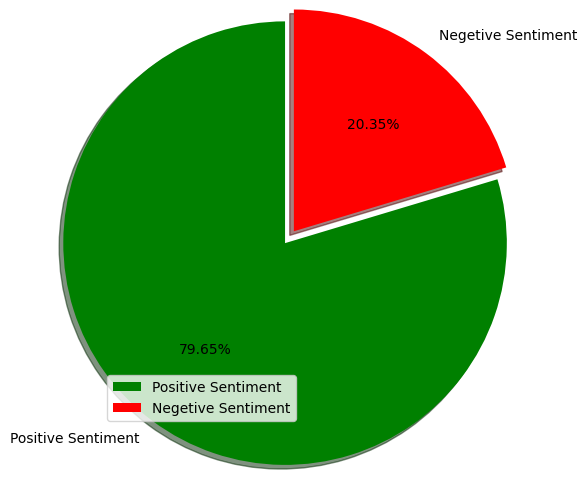

In [83]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## 2.2) Most used positive words

<Figure size 3840x2880 with 0 Axes>

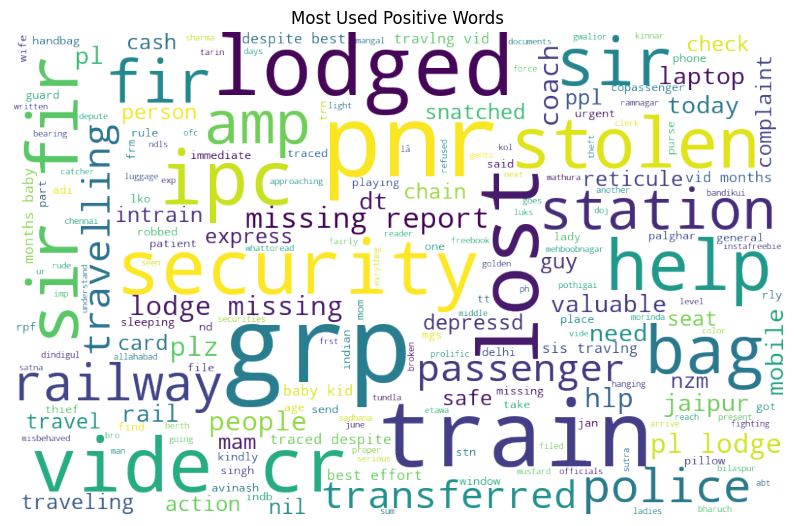

In [84]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.savefig('assets/positive_words.png')
plt.show()

## 2.3) Most used negetive words

<Figure size 3840x2880 with 0 Axes>

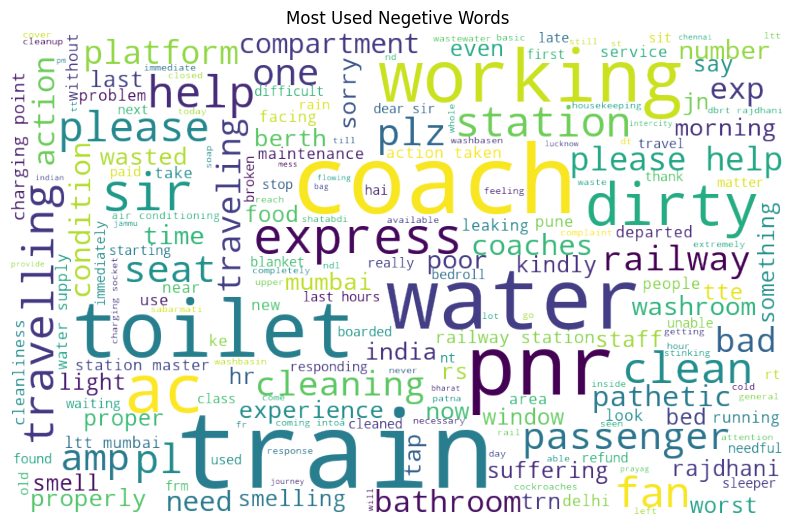

In [85]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
plt.savefig('assets/negetive_words.png')
plt.show()

#### See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.

# 3) Feature extraction (vectorization)

## N-grams included (Unigram, Bigram, Trigram)

*Tf-idf* is different from *CountVectorizer*. *CountVectorizer* gives equal weightage to all the words, i.e. a word is converted to a column (in a dataframe for example) and for each document, it is equal to 1 if it is present in that doc else 0. 
Apart from giving this information, *Tf-idf* says how important that word is to that document with respect to the corpus.

## 3.1) Count vectorizer

As we all know, all machine learning algorithms are good with numbers; we have to extract or convert the text data into numbers without losing much of the information. One way to do such transformation is *Bag-Of-Words (BOW)* which gives a number to each word but that is very inefficient. So, a way to do it is by *CountVectorizer*: it counts the number of words in the document i.e it converts a collection of text documents to a matrix of the counts of occurences of each word in the document.

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(total_data['processed_tweet'])  
final_vectorized_data

<1366x16252 sparse matrix of type '<class 'numpy.int64'>'
	with 36688 stored elements in Compressed Sparse Row format>

## 3.2) Tf-Idf vectorizer

**The below code is commented out because *CountVectorizer* gives better accuracy in this sentiment analysis than *tf-idf*. If you want to check, then uncomment the code below, comment the countVectorizer code above and run the whole code again.**  
<br/>  


In [87]:
# from sklearn.feature_extraction.text import TfidfVectorizer 

# tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
# final_vectorized_data = tf_idf_vectorizer.fit_transform(total_data['processed_tweet'])

# final_vectorized_data

# 4) Splitting

##### Splitting train data to test accuracy

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)  
print(y_train[0:10])

774     5
981     0
1076    0
128     1
1083    4
1064    4
1207    6
715     0
856     0
1018    6
Name: Sentiment, dtype: int64


##### Printing splitted dataset sizes

In [89]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (1092, 16252)
X_test_shape :  (274, 16252)
y_train_shape :  (1092,)
y_test_shape :  (274,)


# 5) Train and predict

## 5.1) Naive_bayes

### Bayes theorem :
![](assets/bayes_formula.jpg)

### There are some popular classifiers under Naive Bayes
* **Bernoulli Naive Bayes**
* **Gaussian Naive Bayes classifier**
* **Multinomial Naive Bayes**

#### We will use Multinomial Naive Bayes classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# Training the classifier
clf.fit(X_train, y_train)
B_pred = clf.predict(X_test)
racc=clf.score(X_test, y_test)

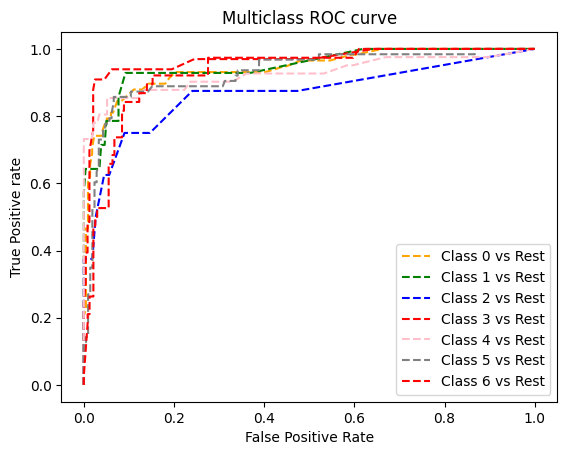

In [91]:
# roc curve for classes

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,probs[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='Gray', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='red', label='Class 6 vs Rest') 

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600);  

In [92]:
from sklearn.svm import SVC
svcmodel=SVC(kernel='rbf', random_state=0,probability=True)
svcmodel.fit(X_train, y_train)

# predict probabilities
svcacc = svcmodel.score(X_test, y_test)
print(acc)

97


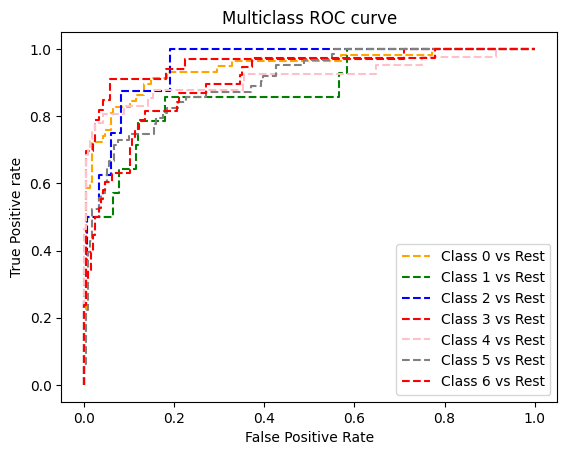

In [93]:
# roc curve for classes

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = svcmodel.predict_proba(X_test)
preds = probs[:,1]
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,probs[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='Gray', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='red', label='Class 6 vs Rest') 

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600); 

In [94]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(solver='lbfgs')
LRmodel.fit(X_train, y_train)
loacc=LRmodel.score(X_test, y_test)
print(lracc) 

87


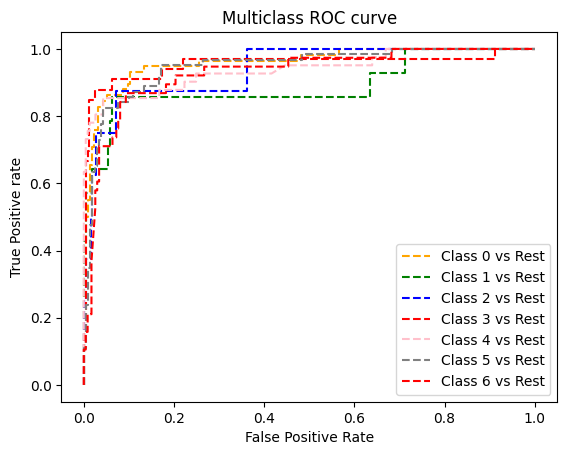

In [34]:
# roc curve for classes

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = LRmodel.predict_proba(X_test)
preds = probs[:,1]
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,probs[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='Gray', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='red', label='Class 6 vs Rest') 

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600);  

In [35]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier
#from sklearn.feature_extraction.text import CountVectorizer

comment2 = ["thanks for give attention on meerut 2 saharanpur railway line"]
 
      
check = count_vectorizer.transform(comment2).toarray() 
check
model_naive = MultinomialNB().fit(X_train, y_train)
nacc=clf.score(X_test, y_test)
predicted_naive = model_naive.predict(check)
print(predicted_naive)
if predicted_naive == 0:
   print("maintenance")
elif predicted_naive == 1:
   print("security ")
elif predicted_naive == 2:
   print("emergency doctor")
elif predicted_naive == 3:
   print("food")
elif predicted_naive == 4:
   print("time/travel")
elif predicted_naive == 5:
   print("tickets")
elif predicted_naive == 6:
   print("feedback")
elif predicted_naive == 7:
   print("resolution")
   

[6]
feedback


## Find out accuracy of our prediction

### Drawing ROC curve

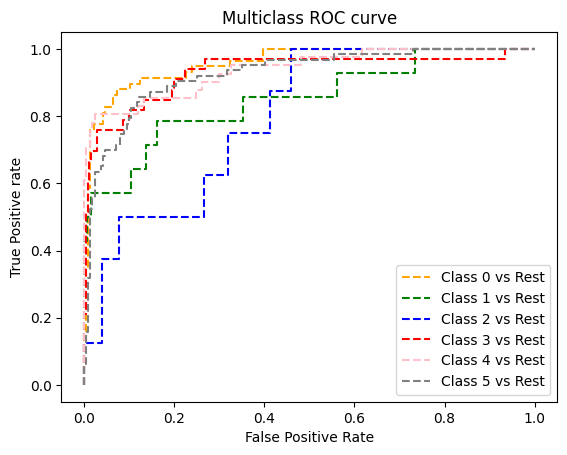

In [36]:
# roc curve for classes

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,probs[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='Gray', label='Class 5 vs Rest')
 

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600);    

In [37]:
from sklearn.ensemble import VotingClassifier

#create a dictionary of base learners
estimators=[('rfc', clf), ('NB', model_naive)]
#create voting classifier
majority_voting = VotingClassifier(estimators, voting='soft')

#fit model to training data
majority_voting.fit(X_train, y_train)
#test our model on the test data
vacc=majority_voting.score(X_test, y_test)
print(vacc)

0.7591240875912408


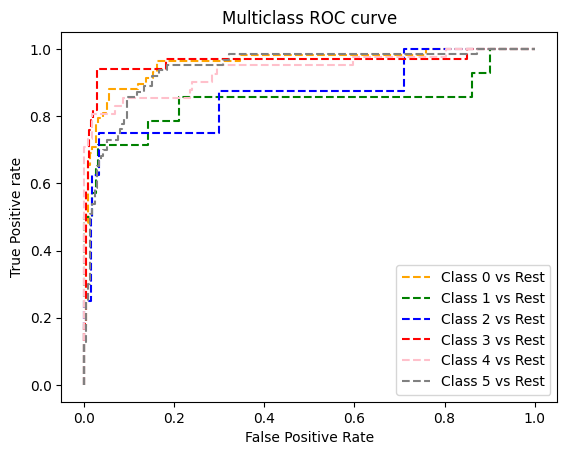

In [38]:
# roc curve for classes

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = majority_voting.predict_proba(X_test)
preds = probs[:,1]
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,probs[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='Gray', label='Class 5 vs Rest')
 

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600);   

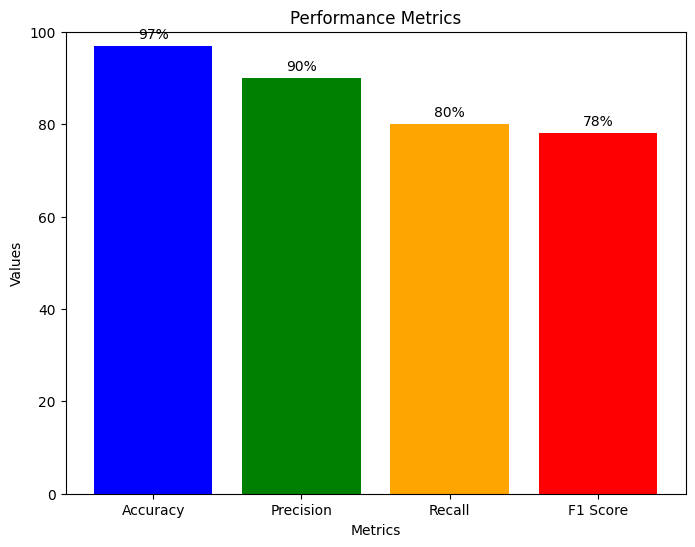

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Performance metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy_vc, precision_vc, recall_vc, f1_vc]

# Colors for each metric
colors = ['blue', 'green', 'orange', 'red']

# Plotting
plt.figure(figsize=(8, 6))

# Bar plot for each metric
plt.bar(metrics, values, color=colors)

# Adding titles and labels
plt.title('Performance Metrics for Voting Classifier')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)  # Limiting y-axis from 0 to 1 for better visualization

# Displaying the plot
plt.show()

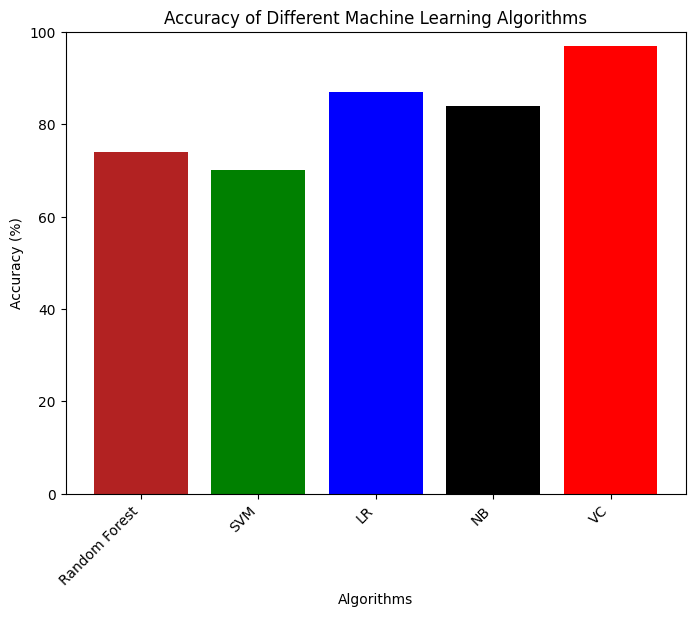

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x=['RandomForest','SVM','LR','NB','VC']
y = [racc, svcacc, loacc,nacc, vacc]
plt.bar(x,y,color=['firebrick', 'green', 'blue', 'black', 'red'])
plt.xlabel('Categories')
plt.ylabel("Values")
plt.title('Categories Bar Plot')
plt.show()